In [1]:
import pandas as pd
from io import StringIO

In [33]:
from matplotlib import pyplot as plt

In [2]:
CSV_VALUES = {}

REFERENCIAS = [(2013,x) for x in range(4,13)] 
REFERENCIAS.extend([(ano, mes) for ano in range(2014,2022) for mes in range(1,13)])
REFERENCIAS.extend([(2022,x) for x in range(1,3)])

for ano, mes in REFERENCIAS:
    with open(f"../data/saude/{ano}{mes:02d}.txt") as fp:
        conteudo = fp.read()
    linhas = [x for x in conteudo.split("\n") if "SC;" in x or "Uf;" in x ]
    CSV_VALUES[f"{ano}{mes:02d}"] = "\n".join(linhas)

In [5]:
DATAFRAMES = {}
for ano, mes in REFERENCIAS: 
    try:
        ref = f"{ano}{mes:02d}"
        df = pd.read_csv(StringIO(CSV_VALUES[ref]),sep=";",thousands=".")
        df.drop(columns=["Uf","Municipio","Unnamed: 15"],inplace=True) 
        df["ano"] = ano
        df["referencia"] = ref
        DATAFRAMES[ref] = df.copy()
    except:
        print(ano,mes)


2013 4
2013 6


In [6]:
doenças = pd.concat(*[DATAFRAMES.values()])

In [241]:
doenças.to_csv("../parsed-data/saude-series.csv",index=False)

In [154]:
população = pd.read_csv("../parsed-data/populacao.csv")

In [158]:
população.set_index("COD_IBGE", inplace=True)

In [176]:
def get_pop(ibge, year):
    if year == 2022:
        year -= 1
    elif year == 2013:
        year += 1
    return população.loc[ibge,str(year)]

def get_pop_df(row):
    return get_pop(row["Ibge"],row["ano"])

In [178]:
doenças["população"] = doenças.apply(get_pop_df, axis=1)

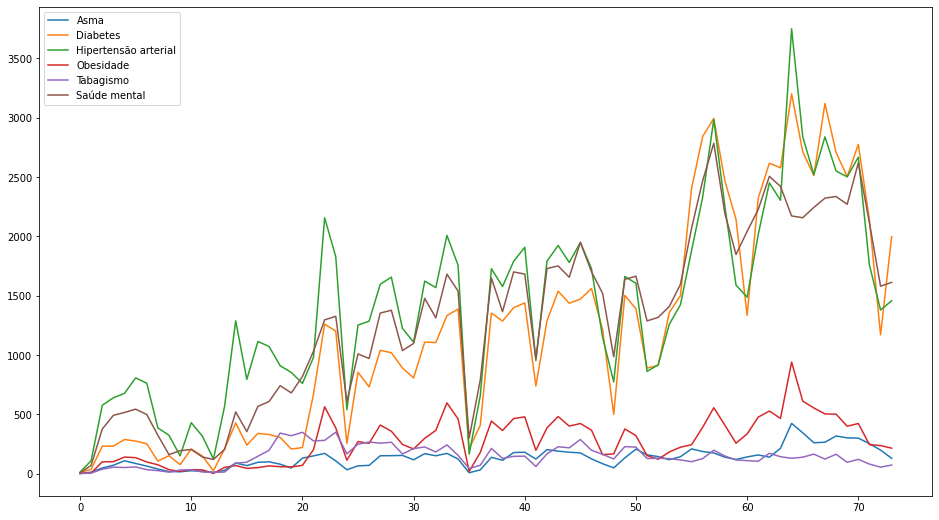

In [43]:
fig, ax = plt.subplots(figsize=(16,9))

doenças.query("Ibge == 420240").reset_index()[["Asma","Diabetes","Hipertensão arterial","Obesidade","Tabagismo","Saúde mental"]].plot(ax=ax)

fig.title = "Blumenau"

<AxesSubplot:>

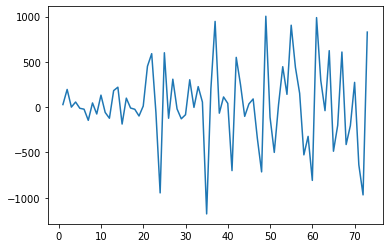

In [46]:
serie

https://www.projectpro.io/article/how-to-build-arima-model-in-python/544#:~:text=Model%20in%20Python%3F-,ARIMA%20Model%2D%20Complete%20Guide%20to%20Time%20Series%20Forecasting%20in%20Python,data%20to%20predict%20future%20values.

In [193]:
subdf = doenças.query("Ibge == 420240").reset_index()[["Diabetes","população"]]
serie = subdf["Diabetes"]/subdf["população"]*1000

In [194]:
serie

0     0.023275
1     0.104738
2     0.672068
3     0.672068
4     0.834994
        ...   
69    6.830996
70    7.576047
71    5.837595
72    3.193075
73    5.452789
Length: 74, dtype: float64

In [195]:
from statsmodels.graphics.tsaplots import plot_acf

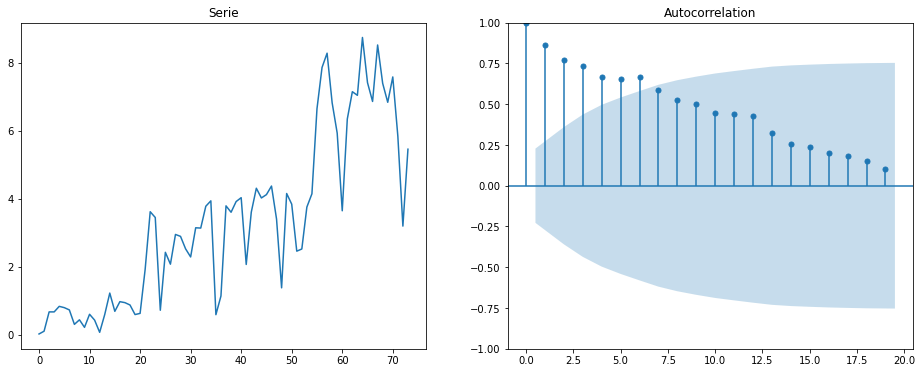

In [196]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.set_title("Serie")
serie.plot(ax=ax1)
plot_acf(serie.dropna(),ax=ax2)

plt.show()

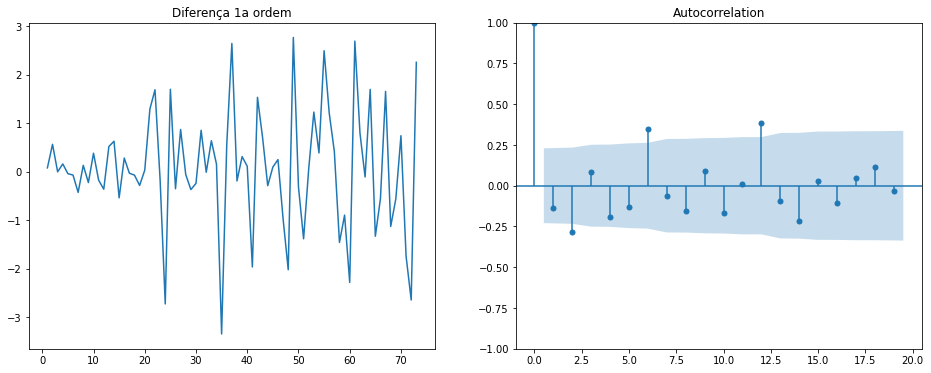

In [197]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.set_title("Diferença 1a ordem")
serie.diff().plot(ax=ax1)
plot_acf(serie.diff().dropna(),ax=ax2)

plt.show()

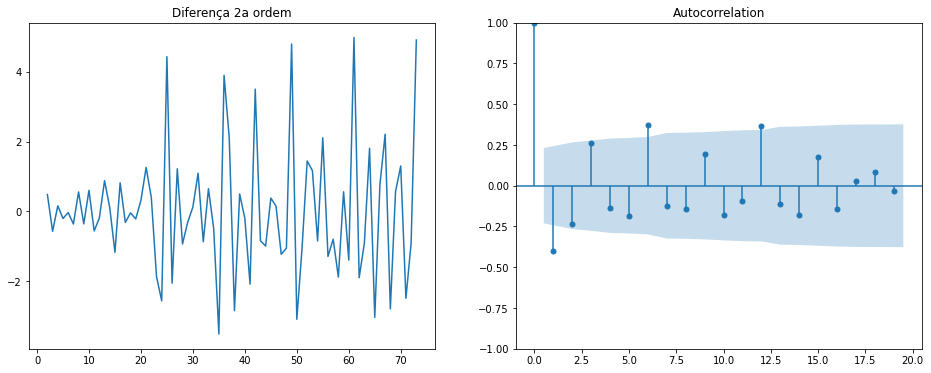

In [198]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.set_title("Diferença 2a ordem")
serie.diff().diff().plot(ax=ax1)
plot_acf(serie.diff().diff().dropna(),ax=ax2)

plt.show()

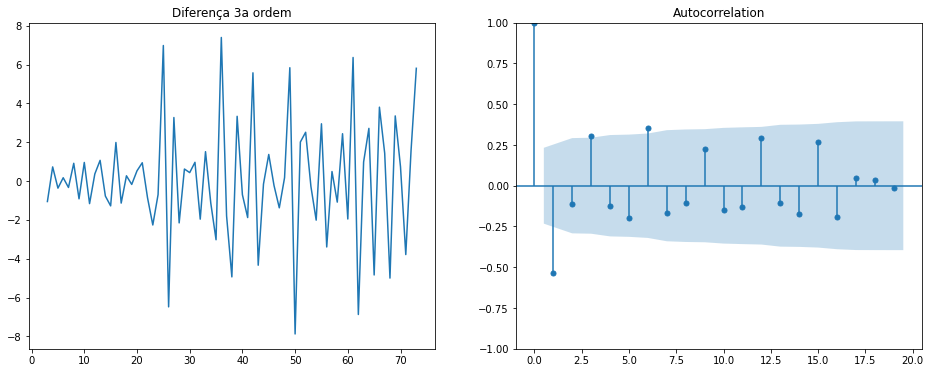

In [199]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(16,6))
ax1.set_title("Diferença 3a ordem")
serie.diff().diff().diff().plot(ax=ax1)
plot_acf(serie.diff().diff().diff().dropna(),ax=ax2)

plt.show()

# Modelo ARIMA

In [200]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(serie.values, order=(3,2,6))
model = arima_model.fit()

/home/bossa/.local/share/virtualenvs/MapaSaudeSC-WJJ64HuV/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [201]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   74
Model:                 ARIMA(3, 2, 6)   Log Likelihood                -106.796
Date:                Mon, 18 Apr 2022   AIC                            233.592
Time:                        11:56:15   BIC                            256.358
Sample:                             0   HQIC                           242.655
                                 - 74                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8041      0.418     -1.922      0.055      -1.624       0.016
ar.L2         -0.8208      0.393     -2.088      0.037      -1.591      -0.050
ar.L3          0.1538      0.431      0.357      0.7

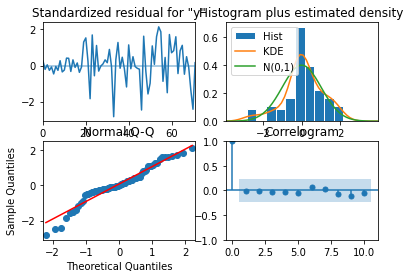

In [202]:
model.plot_diagnostics()
plt.show()

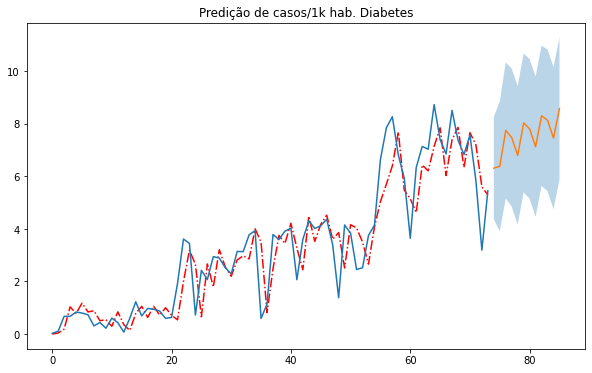

In [204]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Predição de casos/1k hab. Diabetes")
ax.plot(model.predict(),'-.r')
ax.plot(serie.values)
N = len(serie)
fore = model.get_forecast(12)
intervalo_confianca = fore.conf_int()
ic_low = [ x[0] for x in intervalo_confianca]
ic_up = [x[1] for x in intervalo_confianca]
ax.plot(range(N,N+12),fore.predicted_mean)
ax.fill_between(range(N,N+12), ic_low, ic_up, alpha=0.3)
plt.show()

# Modelo SARIMA

In [205]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [235]:
sarima_model = SARIMAX(serie.values, order=(1,1,2), seasonal_order=(1,1,2,3))

In [236]:
model = sarima_model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.57499D+00    |proj g|=  3.34940D-01

At iterate    5    f=  1.41013D+00    |proj g|=  1.58112D-02

At iterate   10    f=  1.39997D+00    |proj g|=  3.39189D-02

At iterate   15    f=  1.38525D+00    |proj g|=  2.46103D-02

At iterate   20    f=  1.38342D+00    |proj g|=  9.51968D-03

At iterate   25    f=  1.38311D+00    |proj g|=  1.37223D-03

At iterate   30    f=  1.38251D+00    |proj g|=  9.79390D-03


 This problem is unconstrained.



At iterate   35    f=  1.38231D+00    |proj g|=  2.07156D-03

At iterate   40    f=  1.38220D+00    |proj g|=  1.64732D-03

At iterate   45    f=  1.38219D+00    |proj g|=  6.51236D-04

At iterate   50    f=  1.38219D+00    |proj g|=  2.54191D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     61      1     0     0   2.542D-04   1.382D+00
  F =   1.3821872021320241     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/home/bossa/.local/share/virtualenvs/MapaSaudeSC-WJJ64HuV/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [237]:
print(model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                   74
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 3)   Log Likelihood                -102.282
Date:                           Mon, 18 Apr 2022   AIC                            218.564
Time:                                   14:19:39   BIC                            234.303
Sample:                                        0   HQIC                           224.816
                                            - 74                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5524      0.209      2.645      0.008       0.143       0.962
ma.L1         -0.8043      7.807     -0.103

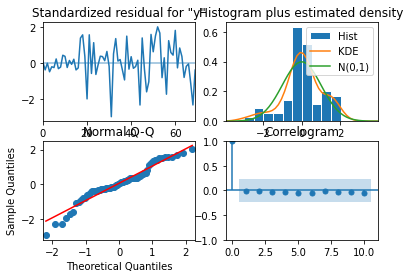

In [233]:
model.plot_diagnostics()
plt.show()

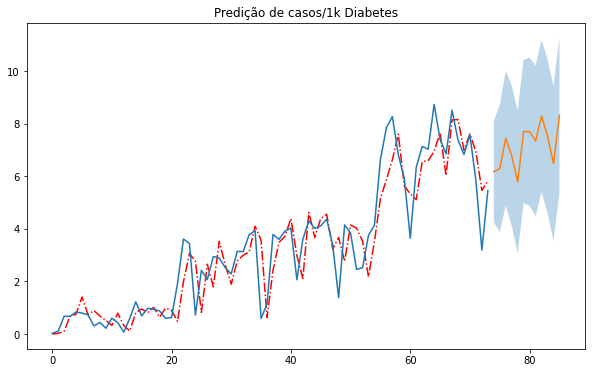

In [240]:
fig, ax = plt.subplots(figsize=(10,6))
ax.set_title("Predição de casos/1k Diabetes")
ax.plot(model.predict(),'-.r')
ax.plot(serie.values)
N = len(serie)
fore = model.get_forecast(12)
intervalo_confianca = fore.conf_int()
ic_low = [ x[0] for x in intervalo_confianca]
ic_up = [x[1] for x in intervalo_confianca]
ax.plot(range(N,N+12),fore.predicted_mean)
ax.fill_between(range(N,N+12), ic_low, ic_up, alpha=0.3)
plt.show()